In [1]:
import json
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm
from datetime import datetime  
import glob
import re
from collections import Counter

sns.set(font_scale=1.4, style="white")

In [2]:
# load data
reddit_combi_df = pd.read_excel(r"D:\Stress-Detection\data\Reddit_Combi.xlsx", engine='openpyxl')
reddit_combi_df.head()
reddit_title_df = pd.read_excel(r"D:\Stress-Detection\data\Reddit_Title.xlsx", engine='openpyxl')
twitter_full_df = pd.read_excel(r"D:\Stress-Detection\data\Twitter_Full.xlsx", engine='openpyxl')
twitter_non_ad_df = pd.read_excel(r"D:\Stress-Detection\data\Twitter_Non-Advert.xlsx", engine='openpyxl')

print(reddit_title_df.shape)
print(reddit_combi_df.shape)
print(twitter_full_df.shape)
print(twitter_non_ad_df.shape)


(5556, 2)
(3123, 4)
(8900, 3)
(2051, 2)


In [3]:
print(reddit_title_df.info())
print(reddit_combi_df.info())
print(twitter_full_df.info())
print(twitter_non_ad_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556 entries, 0 to 5555
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5556 non-null   object
 1   label   5556 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 86.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3123 non-null   object
 1   body        3116 non-null   object
 2   Body_Title  3123 non-null   object
 3   label       3123 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 97.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8900 entries, 0 to 8899
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8900 non-null   object
 1   hashtags  8892 non-null   object
 2   labels    8900 non-null   int

In [4]:
reddit_combi_df.dropna(inplace=True)
twitter_full_df.dropna(inplace=True)            
print(reddit_combi_df.info())
print(twitter_full_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3116 entries, 0 to 3122
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3116 non-null   object
 1   body        3116 non-null   object
 2   Body_Title  3116 non-null   object
 3   label       3116 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 121.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8892 entries, 0 to 8899
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8892 non-null   object
 1   hashtags  8892 non-null   object
 2   labels    8892 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 277.9+ KB
None


In [5]:
# check for duplicates in each column of each dataframe
for df, name in zip([reddit_title_df, reddit_combi_df, twitter_full_df, twitter_non_ad_df],
                    ['Reddit Title', 'Reddit Combi', 'Twitter Full', 'Twitter Non-Ad']):
    print(f"Duplicates in {name} dataframe:")
    for col in df.columns:
        num_duplicates = df[col].duplicated().sum()
        print(f"  Column '{col}': {num_duplicates} duplicates")
    print()

Duplicates in Reddit Title dataframe:
  Column 'title': 34 duplicates
  Column 'label': 5554 duplicates

Duplicates in Reddit Combi dataframe:
  Column 'title': 25 duplicates
  Column 'body': 4 duplicates
  Column 'Body_Title': 0 duplicates
  Column 'label': 3114 duplicates

Duplicates in Twitter Full dataframe:
  Column 'text': 459 duplicates
  Column 'hashtags': 3322 duplicates
  Column 'labels': 8890 duplicates

Duplicates in Twitter Non-Ad dataframe:
  Column 'text': 79 duplicates
  Column 'label': 2049 duplicates



In [6]:
# remove duplicates in text columns, handle missing/empty values
reddit_title_df = reddit_title_df.drop_duplicates(subset=['title'])
reddit_combi_df = reddit_combi_df.drop_duplicates(subset=['title'])
reddit_combi_df = reddit_combi_df.drop_duplicates(subset=['body'])
twitter_full_df = twitter_full_df.drop_duplicates(subset=['text'])
twitter_non_ad_df = twitter_non_ad_df.drop_duplicates(subset=['text'])
print("After removing duplicates:")
print(reddit_title_df.shape)
print(reddit_combi_df.shape)
print(twitter_full_df.shape)
print(twitter_non_ad_df.shape)

for df, name in zip([reddit_title_df, reddit_combi_df, twitter_full_df, twitter_non_ad_df],
                    ['Reddit Title', 'Reddit Combi', 'Twitter Full', 'Twitter Non-Ad']):
    print(f"Duplicates in {name} dataframe:")
    for col in df.columns:
        num_duplicates = df[col].duplicated().sum()
        print(f"  Column '{col}': {num_duplicates} duplicates")
    print()

After removing duplicates:
(5522, 2)
(3087, 4)
(8433, 3)
(1972, 2)
Duplicates in Reddit Title dataframe:
  Column 'title': 0 duplicates
  Column 'label': 5520 duplicates

Duplicates in Reddit Combi dataframe:
  Column 'title': 0 duplicates
  Column 'body': 0 duplicates
  Column 'Body_Title': 0 duplicates
  Column 'label': 3085 duplicates

Duplicates in Twitter Full dataframe:
  Column 'text': 0 duplicates
  Column 'hashtags': 2930 duplicates
  Column 'labels': 8431 duplicates

Duplicates in Twitter Non-Ad dataframe:
  Column 'text': 0 duplicates
  Column 'label': 1970 duplicates



In [7]:
def pre_processing(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^A-Za-z0-9#]+", ' ', text)
    text = re.sub(r'\n','', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

for df in [reddit_title_df, reddit_combi_df, twitter_full_df, twitter_non_ad_df]:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(pre_processing)

In [8]:
print("After processing text:")
print(reddit_title_df.shape)
print(reddit_combi_df.shape)
print(twitter_full_df.shape)
print(twitter_non_ad_df.shape)

# processing did not remove any rows

After processing text:
(5522, 2)
(3087, 4)
(8433, 3)
(1972, 2)


In [9]:
twitter_full_df.head()

,text,hashtags,labels
0,Being s mom is cleaning 24 7 the same shit ove...,momlife kids tired,1
1,And now we have been given the walkthru book b...,walkthru,0
2,Wishing YOU Peace Joy Love JoyTrain MentalHeal...,Peace Joy Love JoyTrain MentalHealth Quote Min...,0
3,speak no evil monkey Can I Be Honest With You ...,therapy help NLP CBT hypnotherapy mentalhealth...,1
4,Psy Do u hv any regrets Me No Psy Are you happ...,,0


In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("english")
stopwords[:10]

[nltk_data] Downloading package stopwords to C:\Users\XPS
[nltk_data]     9500\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [11]:
def remove_stopwords(text):
    text = text.lower()
    x = text.split()
    filtered = [word for word in x if word not in stopwords]
    return ' '.join(filtered)

In [12]:
reddit_title_df['title_nonstop'] = reddit_title_df['title'].apply(remove_stopwords)
reddit_combi_df['title_nonstop'] = reddit_combi_df['title'].apply(remove_stopwords)
reddit_combi_df['body_nonstop'] = reddit_combi_df['body'].apply(remove_stopwords)
reddit_combi_df['text_nonstop'] = reddit_combi_df['Body_Title'].apply(remove_stopwords)
twitter_full_df['text_nonstop'] = twitter_full_df['text'].apply(remove_stopwords)
twitter_full_df['hashtags_nonstop'] = twitter_full_df['hashtags'].apply(remove_stopwords)
twitter_non_ad_df['text_nonstop'] = twitter_non_ad_df['text'].apply(remove_stopwords)

In [17]:
reddit_combi_df.head()

,title,body,Body_Title,label,title_nonstop,body_nonstop,text_nonstop,word_count
0,Envy to other is swallowing me,Im from developingcountry Indonesia and for no...,Envy to other is swallowing me Im from develop...,1,envy swallowing,im developingcountry indonesia temporary work ...,envy swallowing im developingcountry indonesia...,230
1,Nothin outta the ordinary Paradise Job stress ...,Um hello well many can relate im sure After to...,Nothin outta the ordinary Paradise Job stress ...,1,nothin outta ordinary paradise job stress life...,um hello well many relate im sure today convin...,nothin outta ordinary paradise job stress life...,796
2,Almost 49 and the chasm of emptiness has never...,I ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1,almost 49 chasm emptiness never greater,diagnosed severe bi polar longer even get good...,almost 49 chasm emptiness never greater diagno...,109
3,I m happy again,After my closest friend left me in April I hav...,I m happy again After my closest friend left m...,0,happy,closest friend left april finally let go reali...,happy closest friend left april finally let go...,30
4,Is it possible to recover from such a traumati...,I am only 15 and yet I feel my life is already...,Is it possible to recover from such a traumati...,1,possible recover traumatic childhood,15 yet feel life already pit emptiness stomach...,possible recover traumatic childhood 15 yet fe...,312


In [19]:
## Exploratory data analysis 
# 1. Platform level EDA
# a. Histogram of word count per post per platform

reddit_combi_df['word_count'] = reddit_combi_df['Body_Title'].apply(lambda x: len(x.split()))
twitter_full_df['word_count'] = twitter_full_df['text'].apply(lambda x: len(x.split())) + twitter_full_df['hashtags_nonstop'].apply(lambda x: len(x.split()))
twitter_non_ad_df['word_count'] = twitter_non_ad_df['text'].apply(lambda x: len(x.split()))

reddit_combi_df.head(10)

,title,body,Body_Title,label,title_nonstop,body_nonstop,text_nonstop,word_count
0,Envy to other is swallowing me,Im from developingcountry Indonesia and for no...,Envy to other is swallowing me Im from develop...,1,envy swallowing,im developingcountry indonesia temporary work ...,envy swallowing im developingcountry indonesia...,230
1,Nothin outta the ordinary Paradise Job stress ...,Um hello well many can relate im sure After to...,Nothin outta the ordinary Paradise Job stress ...,1,nothin outta ordinary paradise job stress life...,um hello well many relate im sure today convin...,nothin outta ordinary paradise job stress life...,796
2,Almost 49 and the chasm of emptiness has never...,I ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1,almost 49 chasm emptiness never greater,diagnosed severe bi polar longer even get good...,almost 49 chasm emptiness never greater diagno...,109
3,I m happy again,After my closest friend left me in April I hav...,I m happy again After my closest friend left m...,0,happy,closest friend left april finally let go reali...,happy closest friend left april finally let go...,30
4,Is it possible to recover from such a traumati...,I am only 15 and yet I feel my life is already...,Is it possible to recover from such a traumati...,1,possible recover traumatic childhood,15 yet feel life already pit emptiness stomach...,possible recover traumatic childhood 15 yet fe...,312
5,I m finding it hard to find a reason to get up...,Isn t it so horrible that I don t really want ...,I m finding it hard to find a reason to get up...,1,finding hard find reason get mornings,horrible really want die also like really want...,finding hard find reason get mornings horrible...,137
6,I convinced myself I was going to commit suici...,I want to die so badly but I cant do this to t...,I convinced myself I was going to commit suici...,1,convinced going commit suicide sometime next 2...,want die badly cant greeted smiles joy mother ...,convinced going commit suicide sometime next 2...,135
7,all i do is work and i can never catch a break,literally i always have assignments to do with...,all i do is work and i can never catch a break...,1,work never catch break,literally always assignments time never day no...,work never catch break literally always assign...,125
8,Ive decided to get admitted to a hospital inst...,Hi im obviously depressed and have almost kill...,Ive decided to get admitted to a hospital inst...,1,ive decided get admitted hospital instead killing,hi im obviously depressed almost killed countl...,ive decided get admitted hospital instead kill...,164
9,I m doing well but not feeling well,A reflection I ve been under a lot of stress l...,I m doing well but not feeling well A reflecti...,1,well feeling well,reflection lot stress lately 40s middle manage...,well feeling well reflection lot stress lately...,174


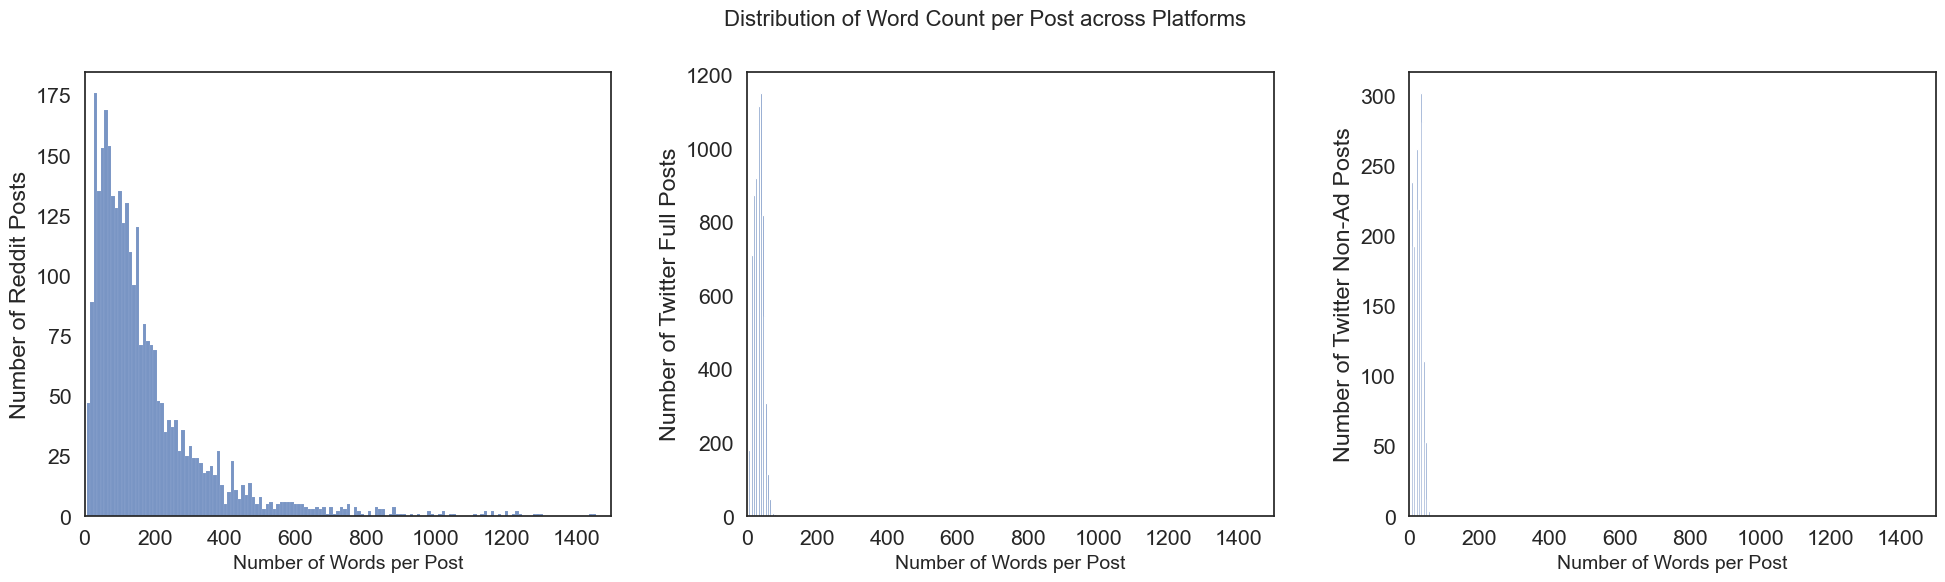

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
#plot the above word count histograms
sns.histplot(data=reddit_combi_df, x="word_count", binwidth=10, ax=ax[0])
ax[0].set_xlabel("Number of Words per Post", fontsize=14)
ax[0].set_ylabel("Number of Reddit Posts")
ax[0].set_xlim(0, 1500)

sns.histplot(data=twitter_full_df, x = "word_count", binwidth=5, ax=ax[1])
ax[1].set_xlabel("Number of Words per Post", fontsize=14)
ax[1].set_ylabel("Number of Twitter Full Posts")
ax[1].set_xlim(0, 1500)

sns.histplot(data=twitter_non_ad_df, x = "word_count", binwidth=5, ax=ax[2])
ax[2].set_xlabel("Number of Words per Post", fontsize=14)
ax[2].set_ylabel("Number of Twitter Non-Ad Posts")
ax[2].set_xlim(0, 1500)

plt.suptitle("Distribution of Word Count per Post across Platforms", fontsize=16)
plt.tight_layout()
plt.show()

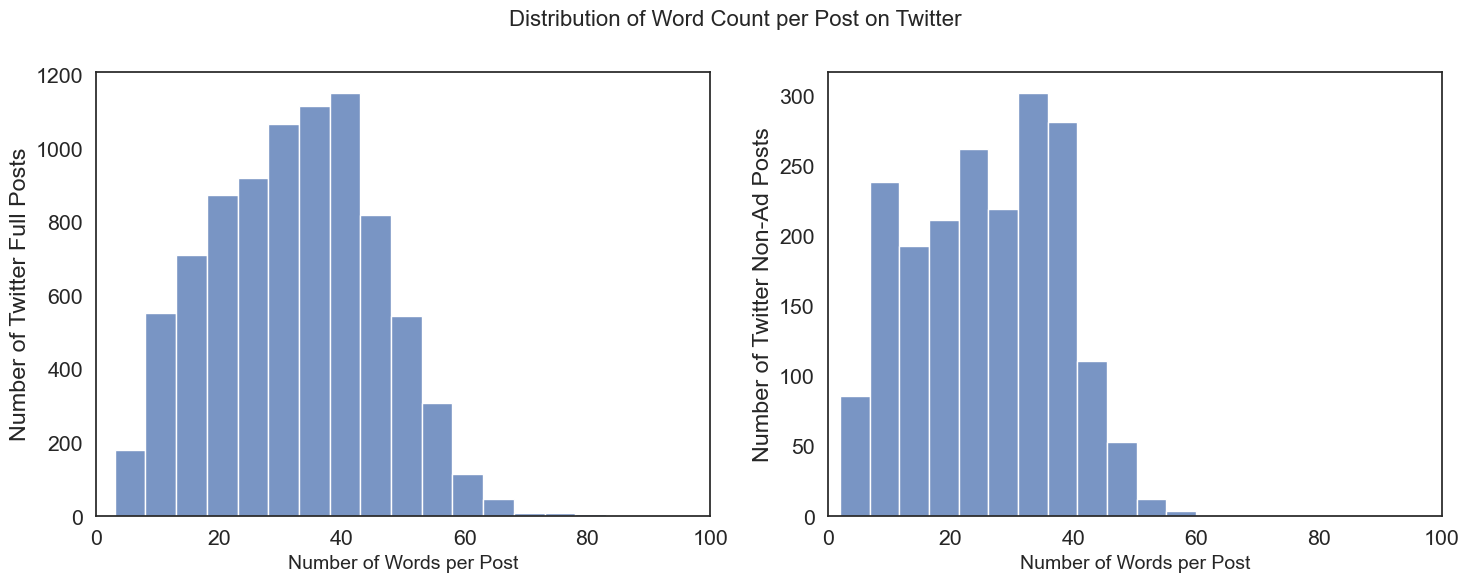

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=twitter_full_df, x = "word_count", binwidth=5, ax=ax[0])
ax[0].set_xlabel("Number of Words per Post", fontsize=14)
ax[0].set_ylabel("Number of Twitter Full Posts")
ax[0].set_xlim(0, 100)

sns.histplot(data=twitter_non_ad_df, x = "word_count", binwidth=5, ax=ax[1])
ax[1].set_xlabel("Number of Words per Post", fontsize=14)
ax[1].set_ylabel("Number of Twitter Non-Ad Posts")
ax[1].set_xlim(0, 100)

plt.suptitle("Distribution of Word Count per Post on Twitter", fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\XPS 9500\AppData\Local\Temp\ipykernel_26532\1933465882.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([reddit_combi_df['unique_word_count'], twitter_full_df['unique_word_count']],


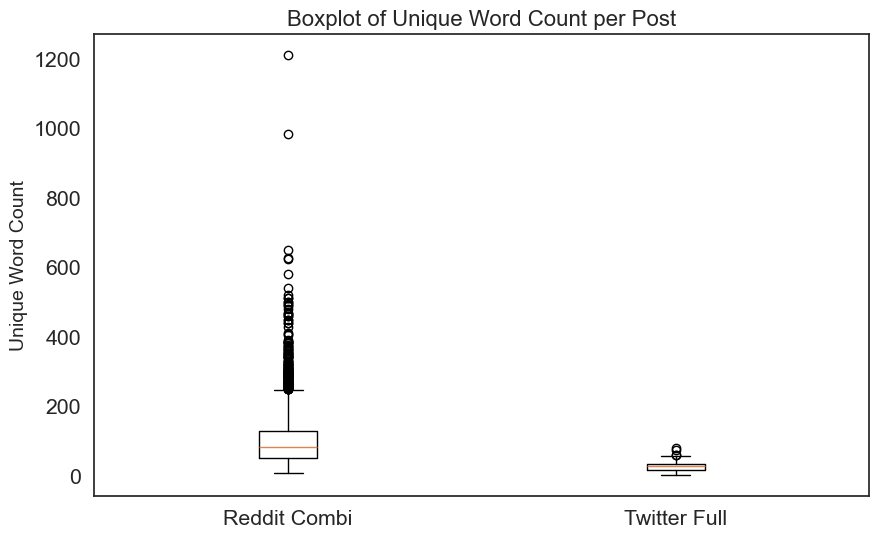

In [29]:
# b. Boxplot of unique word count per post
reddit_combi_df['unique_word_count'] = reddit_combi_df['Body_Title'].apply(lambda x: len(set(x.split())))
twitter_full_df['unique_word_count'] = twitter_full_df['text'].apply(lambda x: len(set(x.split()))) 

plt.figure(figsize=(10, 6))
plt.boxplot([reddit_combi_df['unique_word_count'], twitter_full_df['unique_word_count']],
            labels =['Reddit Combi', 'Twitter Full'])
plt.ylabel("Unique Word Count", fontsize=14)
plt.title("Boxplot of Unique Word Count per Post", fontsize=16)
plt.show()

In [ ]:
from wordcloud import WordCloud